In [23]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt 
from collections import Counter
from scipy import stats
import gseapy as gp
from community import community_louvain
import random as rd
import itertools as it
from networkx.algorithms import bipartite

In [8]:
def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

#Here, we define the fisher test that we will use
def overlap_set(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= background #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used

def read_file_as_lists(file_path):
    """
    Reads a file and converts its content into lists.

    Args:
        file_path (str): Path to the file to be read.

    Returns:
        list of lists: A list where each element is a list of items from each line.
    """
    lists = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Remove leading/trailing whitespace and split by whitespace or commas
                elements = line.strip().replace(",", " ").split()
                lists.append(elements)
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return lists

In [21]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#Here, we create a dictionary out of the dataframe that has as a key the exposures and as 
#values the set of the genes that they perturb
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we remove the elements that do not perturb any genes:       
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass
 
print("The number of exposures is %s" %len(chem_gene_cleaned))
print("The total number of perturbed genes is %s" %len(set(tot_gene_list)))

The number of exposures is 9887
The total number of perturbed genes is 25580


In [22]:
bipartite_G = nx.Graph()
exposures_list = []
genes_list = []
for k,v in chem_gene_cleaned.items():
    if str(k)!='nan':
        exposures_list.append(k)
        for gene in v:
            if str(gene)!='nan':
                genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G.add_node(exposure,s="o", bipartite='exposure')
    for genes in [i for i in chem_gene_cleaned[exposure] if str(i)!='nan']:
        bipartite_G.add_edges_from([(exposure,genes)])

In [67]:
len(set(genes_list))

25579

In [ ]:
bipartite_clustering_coefficient = bipartite.clustering(bipartite_G)

In [ ]:
with open('output/Communities/bipartite_clustering_coefficient.pickle', 'wb') as handle:
    pk.dump(bipartite_clustering_coefficient, handle, protocol=pk.HIGHEST_PROTOCOL)

### Louvain

In [ ]:
#Louvain with Barber modularity 

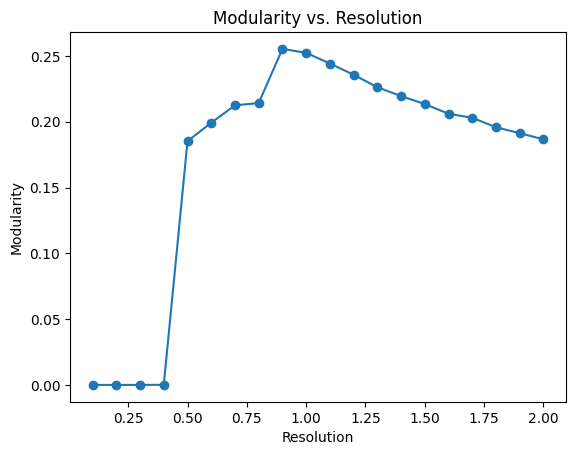

Best Resolution: 0.8999999999999999


In [39]:
import matplotlib.pyplot as plt
from sknetwork.clustering import Louvain
from sknetwork.data import from_edge_list

#Let's see whether we can use Louvain to cluster the bipartite network
#We have used this approach
#https://medium.com/eni-digitalks/uncovering-hidden-communities-in-bipartite-graphs-8a1fc518a04a
#https://scikit-network.readthedocs.io/en/latest/tutorials/clustering/louvain.html

#For bipartite graphs, the algorithm maximizes Barber’s modularity by default.

def compute_modularity(G, partition):
    """
    Compute the modularity of a given partition.
    """
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)
    
    modularity = 0
    m = G.size(weight='weight')
    for community in communities.values():
        subgraph = G.subgraph(community)
        lc = subgraph.size(weight='weight')
        dc = sum([G.degree(node, weight='weight') for node in community])
        modularity += lc / m - (dc / (2 * m)) ** 2
    
    return modularity
    
#Here, we find the resolution parameter that optimizes Barber's modularity
def optimal_resolution_with_diagnostics(G, resolution_list):
    edge_list=[(e[0],e[1]) for e in G.edges(data=True)]
    bgraph = from_edge_list(edge_list, bipartite=True)
    names = bgraph.names
    names_row = bgraph.names_row
    names_col = bgraph.names_col

    biadjacency = bgraph.biadjacency
    
    max_modularity = -1
    best_partition = {}
    best_resolution = None
    modularity_scores = []
    
    for resolution in resolution_list:
        louvain = Louvain(resolution=resolution)
        louvain.fit(biadjacency,force_bipartite=True)
        labels_row = louvain.labels_row_
        labels_col = louvain.labels_col_

        partition = {}
        for i, n_r in enumerate(names_row):
            partition[n_r] = labels_row[i]
        for i, n_c in enumerate(names_col):
            partition[n_c] = labels_col[i]

        modularity = compute_modularity(G, partition)
        modularity_scores.append((resolution, modularity))
        
        if modularity > max_modularity:
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
    
    return best_partition, best_resolution, max_modularity, modularity_scores


resolution_list = np.linspace(0.1, 2, 20) 
best_partition, best_resolution, max_modularity, modularity_scores = optimal_resolution_with_diagnostics(bipartite_G, resolution_list)

# Plot the modularity versus resolution
resolutions, modularities = zip(*modularity_scores)
plt.plot(resolutions, modularities, marker='o')
plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Modularity vs. Resolution')
plt.show()


print("Best Resolution:", best_resolution)

In [40]:

edge_list=[(e[0],e[1]) for e in bipartite_G.edges(data=True)]
bgraph = from_edge_list(edge_list, bipartite=True)
names = bgraph.names
names_row = bgraph.names_row
names_col = bgraph.names_col

biadjacency = bgraph.biadjacency

louvain = Louvain(resolution=0.9)
louvain.fit(biadjacency,force_bipartite=True)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

partition={}
for i,n_r in enumerate(names_row):
    partition[n_r]=labels_row[i]
for i,n_c in enumerate(names_col):
    partition[n_c]=labels_col[i]

partition_rev = {}
for com_partition in set(partition.values()):
    node_list = []
    for node,part in partition.items():   
        if com_partition==part:
            node_list.append(node)
    partition_rev[com_partition] = node_list

print(len(partition_rev))

19


In [41]:
with open('intermediate/bipartite_G_edges_float_Louvain_initial_comm.txt', 'w') as f:
    for com, nodelist in partition_rev.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

In [73]:

#Let's try to see whether the genes that belong to the same community
#are the same genes that are shared between the exposures that belong to the same community
#we will do this by overlapping the shared components with the genes by using the jaccard index

partition_rev_ji_dict = {}

for com,el_list in partition_rev.items():
    explist = set(el_list)&set(exposures_list)
    genelist = set(el_list)&set(genes_list)
    shared_genes = []
    pairwise_exp = list(it.combinations(explist, 2))
    for exp1,exp2 in pairwise_exp:
        shared_genes.extend(list(set(chem_gene_cleaned[exp1])&set(chem_gene_cleaned[exp2])))
    ji = overlap_jaccard(genelist,list(set(shared_genes)))
    partition_rev_ji_dict[com] = ji

In [74]:
np.median(list(partition_rev_ji_dict.values()))

0.5015367053038285

In [75]:
#Let's compute a p-value of overlap
    
partition_rev_pval_dict = {}
partition_rev_fdr_dict = {}

for com,el_list in partition_rev.items():
    explist = set(el_list)&set(exposures_list)
    genelist = set(el_list)&set(genes_list)
    shared_genes = []
    pairwise_exp = list(it.combinations(explist, 2))
    for exp1,exp2 in pairwise_exp:
        shared_genes.extend(list(set(chem_gene_cleaned[exp1])&set(chem_gene_cleaned[exp2])))
    pval = overlap_set(set(genelist),set(shared_genes),len(set(genes_list)))
    partition_rev_pval_dict[com] = float(pval)

adj_pval=fdr_adjustment(list(partition_rev_pval_dict.values()),0.05)
com_list=list(partition_rev_pval_dict.keys())
for i in range(len(adj_pval)):
    partition_rev_fdr_dict[com_list[i]] = adj_pval[i]

sig_partition_rev_fdr_dict = [ i for i in list(partition_rev_fdr_dict.values()) if i<0.05]
print(len(sig_partition_rev_fdr_dict))

16


### Infomap

In [24]:
#from this https://mapequation.github.io/infomap/python/infomap.html#infomap.Infomap.add_multilayer_link
#Let's create a mapping
bipartite_G_node_list = list(bipartite_G.nodes())

mapping_bipartite_G_node = {}
for el in range(len(bipartite_G_node_list)):
    mapping_bipartite_G_node[bipartite_G_node_list[el]] = el

bipartite_G_edges_list = list(bipartite_G.edges())

bipartite_G_edges_mapped_list = []
for e in bipartite_G_edges_list:
    bipartite_G_edges_mapped_list.append((mapping_bipartite_G_node[e[0]],mapping_bipartite_G_node[e[1]]))

In [32]:
from infomap import Infomap
im = Infomap(silent=True, num_trials=10)

for old_n,new_n in mapping_bipartite_G_node.items():
    im.add_node(new_n, old_n)
for new_e in bipartite_G_edges_mapped_list:
    im.add_link(new_e[0],new_e[1])

In [33]:
im.run(bipartite_teleportation=True)
for modules in sorted(im.get_multilevel_modules().values()):
    print(modules)

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


In [34]:
mapping_bipartite_G_node_rev = {}

for old_node,new_node in mapping_bipartite_G_node.items():
    mapping_bipartite_G_node_rev[new_node]=old_node

In [35]:
bipartite_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    bipartite_node_com_dict[mapping_bipartite_G_node_rev[node]]=list(modules)

In [36]:
tot_com_list=[]
for node,com_list in bipartite_node_com_dict.items():
    tot_com_list.extend(com_list)
print(len(set(tot_com_list)))  #This is the total number of communities

bipartite_node_com_up_dict={}
for com in set(tot_com_list):
    node_list=[]
    for node,com_list in bipartite_node_com_dict.items():
        if com in com_list:
            node_list.append(node)
    bipartite_node_com_up_dict[com]=node_list
        
for com,node_list in bipartite_node_com_up_dict.items():
    n_genes = len(set(node_list)&set(genes_list))
    n_exposures = len(set(node_list)&set(exposures_list))
    print("In %s there are %s exposures and %s genes" %(com,n_exposures,n_genes))

174
In 1 there are 1399 exposures and 23672 genes
In 2 there are 3139 exposures and 349 genes
In 3 there are 564 exposures and 22 genes
In 4 there are 573 exposures and 18 genes
In 5 there are 226 exposures and 8 genes
In 6 there are 123 exposures and 17 genes
In 7 there are 123 exposures and 20 genes
In 8 there are 132 exposures and 13 genes
In 9 there are 34 exposures and 20 genes
In 10 there are 45 exposures and 33 genes
In 11 there are 2 exposures and 200 genes
In 12 there are 63 exposures and 16 genes
In 13 there are 127 exposures and 11 genes
In 14 there are 55 exposures and 7 genes
In 15 there are 16 exposures and 62 genes
In 16 there are 109 exposures and 6 genes
In 17 there are 82 exposures and 16 genes
In 18 there are 161 exposures and 5 genes
In 19 there are 78 exposures and 16 genes
In 20 there are 38 exposures and 10 genes
In 21 there are 60 exposures and 13 genes
In 22 there are 37 exposures and 13 genes
In 23 there are 29 exposures and 12 genes
In 24 there are 17 exposur

In [38]:
with open('intermediate/bipartite_G_edges_float_Infomap_initial_comm.txt', 'w') as f:
    for com, nodelist in bipartite_node_com_up_dict.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

In [61]:


#Let's try to see whether the genes that belong to the same community
#are the same genes that are shared between the exposures that belong to the same community
#we will do this by overlapping the shared components with the genes by using the jaccard index

bipartite_node_com_up_ji_dict = {}

for com,el_list in bipartite_node_com_up_dict.items():
    explist = set(el_list)&set(exposures_list)
    genelist = set(el_list)&set(genes_list)
    shared_genes = []
    pairwise_exp = list(it.combinations(explist, 2))
    for exp1,exp2 in pairwise_exp:
        shared_genes.extend(list(set(chem_gene_cleaned[exp1])&set(chem_gene_cleaned[exp2])))
    ji = overlap_jaccard(genelist,list(set(shared_genes)))
    bipartite_node_com_up_ji_dict[com] = ji

In [70]:
#Let's compute a p-value of overlap
    
bipartite_node_com_up_pval_dict = {}
bipartite_node_com_up_fdr_dict = {}

for com,el_list in bipartite_node_com_up_dict.items():
    explist = set(el_list)&set(exposures_list)
    genelist = set(el_list)&set(genes_list)
    shared_genes = []
    pairwise_exp = list(it.combinations(explist, 2))
    for exp1,exp2 in pairwise_exp:
        shared_genes.extend(list(set(chem_gene_cleaned[exp1])&set(chem_gene_cleaned[exp2])))
    pval = overlap_set(set(genelist),set(shared_genes),len(set(genes_list)))
    bipartite_node_com_up_pval_dict[com] = float(pval)

adj_pval=fdr_adjustment(list(bipartite_node_com_up_pval_dict.values()),0.05)
com_list=list(bipartite_node_com_up_pval_dict.keys())
for i in range(len(adj_pval)):
    bipartite_node_com_up_fdr_dict[com_list[i]] = adj_pval[i]

sig_bipartite_node_com_up_fdr_dict = [ i for i in list(bipartite_node_com_up_fdr_dict.values()) if i<0.05]
print(len(sig_bipartite_node_com_up_fdr_dict))

149


### Bilouvain

In [ ]:
#Bipartite Louvain
#As initial conditions, we have used the communities identified in the bipartite network by using Louvain
#There are 19 initial communities, with an initial Murata+ Modularity of 0.25
#After having run biLouvain algorithm, we obtained only 2 communities, with a Murata+ Modularity of 0.25 (no modularity change)



In [13]:

filename = 'intermediate/biLouvain/bipartite_G_edges_float_BipLouvain_ResultsCommunities.txt'
result = read_file_as_lists(filename)

BipLouvain_communities_dict = {}
with open(filename, 'r') as file:
    for line in file:
        if 'Community' in line:
            com_name = line.split(":")[0]
            com_el = line.split(":")[1]
            BipLouvain_communities_dict[com_name] = com_el


In [14]:
len(BipLouvain_communities_dict)

2

In [16]:
BipLouvain_communities_dict.keys()

dict_keys(['Community 0[V2]', 'Community 1[V2]'])

In [21]:
len(BipLouvain_communities_dict['Community 0[V2]'].split(",")) + len(BipLouvain_communities_dict['Community 1[V2]'].split(","))

35466

In [11]:
#Bipartite Infomap



#As initial conditions, we have used the communities identified in the bipartite network by using Infomap
#There are 174 initial communities, with an initial Murata+ Modularity of 0.25
#After having run biLouvain algorithm, we obtained only 2 communities, with a Murata+ Modularity of 0.36

filename = 'intermediate/biLouvain/bipartite_G_edges_float_BipInfomap_ResultsCommunities.txt'
result = read_file_as_lists(filename)

BipInfomap_communities_dict = {}
with open(filename, 'r') as file:
    for line in file:
        if 'Community' in line:
            com_name = line.split(":")[0]
            com_el = line.split(":")[1]
            BipInfomap_communities_dict[com_name] = com_el



In [12]:
len(BipInfomap_communities_dict)

2

In [22]:
len(BipInfomap_communities_dict['Community 0[V2]'].split(",")) + len(BipInfomap_communities_dict['Community 1[V2]'].split(","))

35466

In [9]:
#Infomap Fine-grained Communities


#As initial conditions, we have used the intermediate communities identified in the EEN (n=461) and the GGN (n=458) by using Infomap
#There are 919 initial communities, with an initial Murata+ Modularity of 0.09
#After having run biLouvain algorithm, we obtained 2 communities, with a Murata+ Modularity of 0.49

filename = 'intermediate/biLouvain/bipartite_G_edges_float_FineInfomap_ResultsCommunities.txt'
result = read_file_as_lists(filename)

FineInfomap_communities_dict = {}
with open(filename, 'r') as file:
    for line in file:
        if 'Community' in line:
            com_name = line.split(":")[0]
            com_el = line.split(":")[1]
            FineInfomap_communities_dict[com_name] = com_el

In [10]:
len(FineInfomap_communities_dict)

2

In [ ]:
#Louvain  

In [2]:
#Import the networks
filtered_weighted_gene_graph_significant = nx.read_weighted_edgelist("output/backbone_gene_graph_significant_weighted.edgelist")
filtered_weighted_exp_graph_significant = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")


In [4]:
filtered_weighted_exp_graph_significant_best_partition = community_louvain.best_partition(
    filtered_weighted_exp_graph_significant,
    resolution=0.9,
    weight='weight',
    random_state=5495
)

In [5]:
filtered_weighted_exp_graph_significant_best_partition_rev = {}
for com_partition in set(filtered_weighted_exp_graph_significant_best_partition.values()):
    node_list = []
    for node,part in filtered_weighted_exp_graph_significant_best_partition.items():   
        if com_partition==part:
            node_list.append(node)
    filtered_weighted_exp_graph_significant_best_partition_rev[com_partition] = node_list

print(len(filtered_weighted_exp_graph_significant_best_partition_rev))

125


In [111]:
filtered_weighted_gene_graph_significant_best_partition = community_louvain.best_partition(
    filtered_weighted_gene_graph_significant,
    resolution=0.95,
    weight='weight',
    random_state=5495
)



In [114]:
filtered_weighted_gene_graph_significant_best_partition_rev = {}
for com_partition in set(filtered_weighted_gene_graph_significant_best_partition.values()):
    node_list = []
    for node,part in filtered_weighted_gene_graph_significant_best_partition.items():   
        if com_partition==part:
            node_list.append(node)
    filtered_weighted_gene_graph_significant_best_partition_rev[com_partition] = node_list

print(len(filtered_weighted_gene_graph_significant_best_partition_rev))

81


In [115]:
with open('output/bipartite_G_edges_float_Louvain_initial_comm_both_best.txt', 'w') as f:
    for com, nodeset in filtered_weighted_gene_graph_significant_best_partition_rev.items():
        nodelist = list(nodeset)
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")
    for com, nodelist in filtered_weighted_exp_graph_significant_best_partition_rev.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

In [4]:
#Louvain Best Communities


#As initial conditions, we have used the communities identified in the EEN (n=125) and the GGN (n=81) by using Louvain
#There are 206 initial communities, with an initial Murata+ Modularity of 0.09
#After having run biLouvain algorithm, we obtained 3 communities, with a Murata+ Modularity of 0.22

filename = 'intermediate/biLouvain/bipartite_G_edges_float_BestLouvain_ResultsCommunities.txt'
result = read_file_as_lists(filename)

BestLouvain_communities_dict = {}
with open(filename, 'r') as file:
    for line in file:
        if 'Community' in line:
            com_name = line.split(":")[0]
            com_el = line.split(":")[1]
            BestLouvain_communities_dict[com_name] = com_el

In [5]:
len(BestLouvain_communities_dict)

3

In [7]:
BestLouvain_communities_dict.keys()

dict_keys(['Community 0[V1]', 'Community 1[V2]', 'Community 2[V2]'])

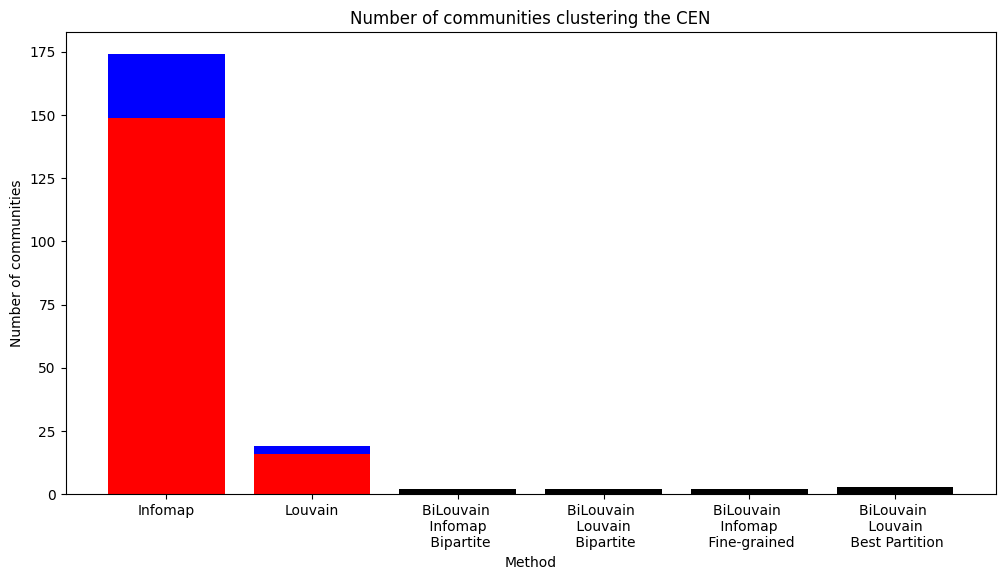

In [6]:

# Data for the stacked bar
data = [174, 19, 2, 2, 2,3]
infomap_stacked_data = [149, 25]
louvain_stacked_data = [16, 3]

# Labels for the x-axis
labels = ['Infomap', 'Louvain', 'BiLouvain \n Infomap \n Bipartite', 
          'BiLouvain \n Louvain \n Bipartite', 
          'BiLouvain \n Infomap \n Fine-grained',
          'BiLouvain \n Louvain \n Best Partition'
         ]

fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked bar for the first element
ax.bar(labels[0], infomap_stacked_data[0], color='red')  # Add the bottom part (red)
ax.bar(labels[0], infomap_stacked_data[1], bottom=infomap_stacked_data[0], color='blue')  # Add the top part (blue)

ax.bar(labels[1], louvain_stacked_data[0], color='red')  # Add the bottom part (red)
ax.bar(labels[1], louvain_stacked_data[1], bottom=louvain_stacked_data[0], color='blue')  # Add the top part (blue)

# Create the rest of the bars
ax.bar(labels[2:], data[2:], color='black')

# Add titles and labels
plt.xlabel('Method')
plt.ylabel('Number of communities')
plt.title('Number of communities clustering the CEN')

plt.savefig('output/Figures/SF2A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()